In [8]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
from ibsen.orbit import Orbit
from ibsen.winds import Winds
from ibsen.ibs import IBS


In [9]:

DAY = 86400.
AU = 1.5e13

sys_name = 'psrb' 
orb = Orbit(sys_name = sys_name, n=1003)


In [10]:
from ibsen.winds import Winds

# having initialized orb:Orbit, initialize winds:Winds

winds = Winds(orbit=orb, sys_name = sys_name, alpha=-10/180*pi, incl=23*pi/180,
              f_d=165, f_p=0.1, delta=0.02, np_disk=3, rad_prof='pl', r_trunk=None,
             height_exp=0.25)


Now it's time to do something useful. Let's calculate the spectrum of relativistic electrons in each point of IBS that we have just initialized. There are many parameters that you should/may specify for this, so the full list is in the example below right in the Python code, with descriptions and default values. 

Here I will only comment on the parameter ``cooling`` that specifies which model of electrons evolution would you like to use. 

First of all, you can set ``cooling='no'``, and the spectrum of electrons in each $s$ will be (numerically) set to $Q_\mathrm{inj}(s, E)$. Note that from the physical point of view this is nonsense, as $Q$ is the number of $\mathrm{e}^-$ injected per unit of time ($\mathrm{s}^{-1}$), so $Q\times (E/\dot E)$ gives the numer of particles, but setting ``cooling='no'`` ignores the dimentions difference and just sets $n(s, E) = Q(s, E)$.

There are several options of various stationary distributions in each point $s$. ''Stationary'' means that the equation
$$ \frac{\mathrm{d}(n(s, E) \dot E(s, E))}{\mathrm{d}E} = Q_\mathrm{inj}(s, E)$$ 
is being solved analytically in each point of $s$, yielding
$$ n(s, E) = \frac{1}{|\dot E(s,E)|} \int_E^\infty Q(s, \xi) \mathrm{d}\xi. $$ 
Here 
$$\dot E(s, E) = \eta_\mathrm{syn}\dot E_\mathrm{syn} (B(s), E) + \eta_\mathrm{IC}\dot E_\mathrm{IC} (u_\gamma(s), E) - \frac{E}{t_a}$$.

- ``cooling=stat_apex`` calculates the stationary e-spectrum on each $s$ using magnetic and photon fields as in the IBS apex;
- ``cooling=stat_ibs`` calculates the stationary e-spectrum on each $s$ using magnetic and photon fields in this point on IBS;
- ``cooling=stat_mimic`` calculates the stationary e-spectrum on each $s$ with the ''adiabatic time'' $t_a$ calculated to mimic the ''proper'' advection equation solution:
  $$
  t_a = \frac{s_\mathrm{max~g}}{\Gamma_\mathrm{max}-1} \sqrt{\Gamma_\mathrm{bulk}(s)^2-1}.
  $$
- ``cooling=adv`` solves the 2-dimentional advection-over-s + coooling-over-e equation
$$
    v(s) \frac{\partial n}{\partial s} + \frac{\partial (n \dot E(s, E))}{\partial E} = \tilde{Q}_\mathrm{inj}(s, E)
$$
with the same $\dot E$ as before but without ''advection losses''.

**Note.** I was also working on the idea of the equation with "leakage". If we change the term $v \partial / \partial s \rightarrow 1/T_\mathrm{eff}$ (and it can be done accurately), the following equation with leakage is obtained, with s as a parameter:
$$
\frac{\mathrm{d}(n\dot E)}{\mathrm{d}E} + \frac{n}{T_\mathrm{eff}} = Q_\mathrm{inj}
$$
which also has an analytical solution and, anyway, it is ODE and so it seems like it's a good idea to reduce the 2-simentional PDE to a set of (independent, for each $s$) ODE. In reality, though, it turnes out that solvind it we meet some numerical problems and the total time to solve this for each $s$ takes approximately the same time as just solving the transport PDE. So for now I allowed options ``cooling=leak_apex``, ``cooling=leak_ibs``, and ``cooling=leak_mimic``, but I have not tested them, and it seems like some numerical problems sometimes arise there. 

**The class ibs:IBS that you pass to class ``el_ev:ElectronsOnIBS`` should have been initialized not with manual ``beta``, but with the class ``winds:Winds`` (see previous section). This ``ibs:IBS`` class should be with dimentionless coordinates, that is, NOT the one obtaied with ``rescale_to_position()``**.

**Currently you are free to pass any parameters of the magnetic field in the IBS apex from the pulsar and from the optical star, but when recalculating these values to points on IBS, I assume that all the fields are such that**
$$B \propto r^{-1}$$.

**The photon field is calculated with the ``Topt`` that your dictionary of parameter should have contained at the stage of ``orbit:Orbit`` initialization. The photon field if a purely blackbody optical star radiation.**

At the moment of initializing the class, the spectra $n_e(s,E)$ are not calculated yet (as the calculation may take a while but you maybe just want to know how the magnetic field is distributed along the shock and don't care for e-spectrum). To actually calculate $n_e$, you should do  ``els.calculate()``.

eff beta is 0.05443105871290789


/home/alvkuzin/whole_psrb_project/src/ibsen/el_ev.py:172: RuntimeWarning: divide by zero encountered in divide
  inv_Tf = 1 / (Ts * Edots)
/home/alvkuzin/whole_psrb_project/src/ibsen/el_ev.py:178: RuntimeWarning: invalid value encountered in subtract
  inner_int2d = inner_int_spl(eepr) - inner_int_spl(ee)


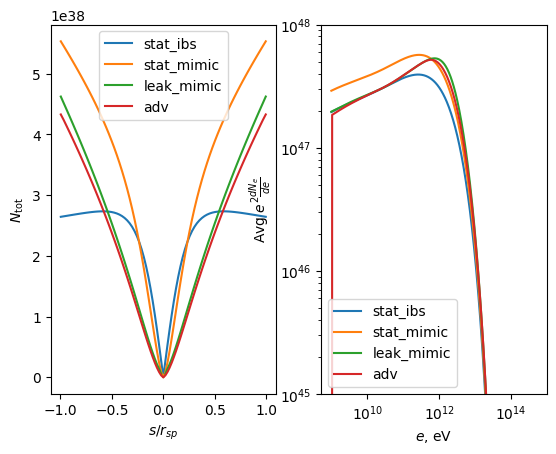

In [7]:
from ibsen.el_ev import ElectronsOnIBS
from scipy.integrate import trapezoid

##### let's again initialize an IBS at, say, 15 days after periastron. Let's do that for three different 
##### models of cooling: stat_ibs, stat_mimic, and adv.
t = 15 * DAY
Nibs = 41
ibs = IBS(beta=None,
          winds=winds,
          gamma_max=3.,
          s_max=1.,
          s_max_g=4.,
          n=Nibs,
          one_horn=False,
           t_to_calculate_beta_eff=t) # the same IBS as before
print('eff beta is', ibs.beta)
r = orb.r(t=t)
rsp = r - winds.dist_se_1d(t)
fig, ax = plt.subplots(nrows=1, ncols=2)

for cooling in ('stat_ibs',
                'stat_mimic',
                'leak_mimic', # can trigger some warnings, not tested!
                'adv'
                ):
    if cooling in ('adv', 'leak_mimic'): eta_a = 1e20 # to dump ``adiabatic losses`` for advection model
    else: eta_a = 1
        
    els = ElectronsOnIBS(
                         Bp_apex=1, # The magnetic field [G] in the Apex of the IBS coming from pulsar. Mandatory.
                         ibs=ibs, # The IBS at which the e-spec should be calculated. Mandatory.
                         cooling=cooling, # How to cool the particles. Default is None.
                         to_inject_e = 'ecpl', # The injection spectrum keyword. Current options: 'ecpl' (default) or 'pl'.
                         to_inject_theta = '3d', # If '2d', then injection distribution over theta is uniform. 
                                                 # If '3d' (default), then \propto sin(theta). 
        
                         ecut = 5.e12,  # Cutoff energy [eV] for ecpl. Default is 1e12.
                         p_e = 1.8, # the injection spectrum index. Default is 2.
                         to_cut_e = True, # If to set injecttion spectrum to 0 outside of the band emin < e < emax. Default is True.
                         emin = 1e9, # If to_cut_e == True, then it is the min e-energy of inj spectrum [eV]. Default is 1e9. 
                         emax = 5e14, # If to_cut_e == True, then it is the max e-energy of inj spectrum [eV]. Default is 5.1e14. 
                         norm_e = 1.e37, # the overall normalization of the injection spectrum. Default is 1e37. 
                                         # if cooling != 'no', then norm_e is treated as total number of injected e- / second.
        
                         Bs_apex=0., # The magnetic field [G] in the Apex of the IBS coming from opt. star. Default is 0.
                         eta_a = eta_a, # t_a = eta_a * dist/c. Can be either a float of None. If None, then the value
                                        # 1e20 is used. It is hardcoded that any value above 1e10 is essentially infinity,
                                        # so if you want no adiabatic losses, pass either eta_a > 1e10 or eta_a = None.
                                        #    Default is None.
        
                         eta_syn = 1., # coef before synchrotron losses term. Default is 1.
                         eta_ic = 1., # coef before IC losses term. Default is 1.
                         to_cut_theta =  False, # If to inject only at theta < where_cut_theta.
                         where_cut_theta = pi/2, # If to_cut_theta == True, then non-zero injection is only at theta < where_cut_theta.
                                                 # Default if pi/2. 
                         ) 
    
    dNe_de_IBS, e_vals = els.calculate(
                                       to_set_onto_ibs=True, # If to remember the calculated e-spec so you can access it as
                                                             # the class attributes later. Default is True.
                                       
                                       to_return=True        # If to return 2d-spectra (on s_grid x e_vals) and e_vals. Default is False.
                                       )
    ### This dNe_de_IBS is a 2d array so that [:, j] is a slice over s at j-th energy, and [i, :] is a slice over e in i-th point of IBS
    ntot = trapezoid(dNe_de_IBS, e_vals, axis=1) # The total number of e at each s of IBS
    dNe_de_IBS_avg = trapezoid(dNe_de_IBS[Nibs+1:2*Nibs-1, :],
                               ibs.s[Nibs+1:2*Nibs-1],
                               axis=0) / np.max(ibs.s) # the e-spectrum averaged over the upper horn of the IBS except the 1st point
    
    
    ### let's plot the n_tot as function of theta...
    #ax[0].plot(ibs.theta / pi * 180, ntot, label  = cooling)
    ax[0].plot(ibs.s, ntot, label  = cooling)
    #ax[0].set_xlabel(r'$\theta$, deg')
    ax[0].set_xlabel(r'$s/r_{sp}$')
    
    ax[0].set_ylabel(r'$N_\mathrm{tot}$')
    ax[0].legend()
    
    ### ... and the average e-spectrum 
    ax[1].plot(e_vals, e_vals**2 * dNe_de_IBS_avg, label = cooling)
    #ax[1].plot(e_vals, e_vals**2 * dNe_de_IBS[20, :], label = cooling)
    
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel(r'$e$, eV')
    ax[1].set_ylabel(r'Avg $e^2\frac{dN_e}{de}$')
    ax[1].legend()
    ax[1].set_ylim(1e45, 1e48)
